In [1]:
import pandas as pd
import textblob
import sqlite3
import numpy as np

# Path hack
import os
# change directory from the current Analysis folder to the top level folder for easier navigation
os.chdir('../')
# confirm we're at top level folder
print(os.getcwd())

# note that the %load_ext autoreload line only needs to be be run once
%load_ext autoreload

/Users/prcork/Georgetown/Spring2023/TimeSeries/ANLY560_website


In [2]:
# import text analysis functions
%autoreload
from _functions import get_reddit_data, text_analysis

Version 7.6.0 of praw is outdated. Version 7.6.1 was released Friday November 11, 2022.


In [3]:
with sqlite3.connect("_data/magic_reddit.db") as conn:

    submissions = pd.read_sql_query("SELECT * FROM submissions", conn)
    print("Total Submissions: " + str(len(submissions)))

    comments = pd.read_sql_query("SELECT * FROM comments", conn)
    print("Total Comments: " + str(len(comments)))

Total Submissions: 2000
Total Comments: 412214


In [4]:
# get textblob subjectivity and polarity
submissions = text_analysis.get_sentiment(submissions, 'title')
comments = text_analysis.get_sentiment(comments, 'body')

In [5]:
# process dates

comments['date']=pd.to_datetime(comments['utc_time'], unit='s').apply(lambda x: x.date())
comments.date = pd.to_datetime(comments.date)

submissions.date = pd.to_datetime(submissions.date)

In [6]:
# split into separate dfs for updating comments

finance = submissions.query("subreddit=='mtgfinance'").copy()
mtg = submissions.query("subreddit=='magicTCG'").copy()

In [7]:
comments["subreddit"] = np.where(comments["submission_id"].isin(finance.submission_id.tolist()), "mtgfinance", "magicTCG")

In [14]:
comments.sample(3)

,comment_id,submission_id,author,body,upvotes,utc_time,author_flair,lem,sub,pol,date,subreddit
184435,iexob5e,vrgrph,Lord_Jaroh,There is a wide range in between a Chronicles-...,0,1.657024e+09,None,There is a wide range in between a Chronicles-...,0.450000,0.10000,2022-07-05,magicTCG
161175,icjcobv,vdavbl,Oberon_Swanson,I can't remember a full set tanking this hard....,21,1.655348e+09,None,I ca n't remember a full set tanking this hard...,0.412879,0.02803,2022-06-16,mtgfinance
373793,ixcjtzh,z1rrrl,MTGCardFetcher,"\n[Izoni, Thousand-Eyed](https://cards.scryf...",7,1.669121e+09,Phyrexian,Izoni Thousand-Eyed http cards.scryfall.io/nor...,0.000000,0.00000,2022-11-22,magicTCG


In [8]:
# group by date and take average

time_subs = submissions.groupby(['date']).mean()
time_subs.reset_index(inplace=True)

time_comments = comments.groupby('date').mean()
time_comments.reset_index(inplace=True)

time_finance = finance.groupby('date').mean()
time_finance.reset_index(inplace=True)

time_mtg = mtg.groupby('date').mean()
time_mtg.reset_index(inplace=True)

time_comments_f = comments.query("subreddit=='mtgfinance'").copy().groupby('date').mean()
time_comments_f.reset_index(inplace=True)
time_comments_m = comments.query("subreddit=='magicTCG'").copy().groupby('date').mean()
time_comments_m.reset_index(inplace=True)

In [13]:
time_comments_f['subreddit'] = 'mtgfinance'
time_comments_m['subreddit'] = 'magictcg'
time_comments 

,date,upvotes,utc_time,sub,pol
0,2022-02-12,6.0,1.644688e+09,0.338828,0.032449
1,2022-02-13,2.0,1.644781e+09,0.500000,0.000000
2,2022-02-14,3.0,1.644864e+09,0.443750,0.000000
3,2022-02-15,2.0,1.644944e+09,0.433571,0.000000
4,2022-02-16,2.0,1.645031e+09,0.445437,0.000000
...,...,...,...,...,...
361,2023-02-08,2.0,1.675874e+09,0.471958,0.049028
362,2023-02-09,2.0,1.675965e+09,0.457143,0.032619
363,2023-02-10,2.0,1.676038e+09,0.475000,0.021605
364,2023-02-11,2.0,1.676123e+09,0.405357,0.000000


<AxesSubplot:>

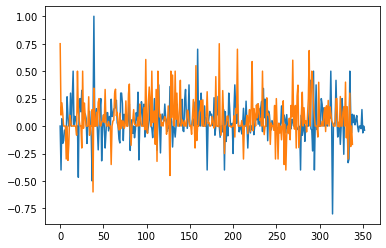

In [9]:
time_finance['pol'].plot()
time_mtg['pol'].plot()

<AxesSubplot:>

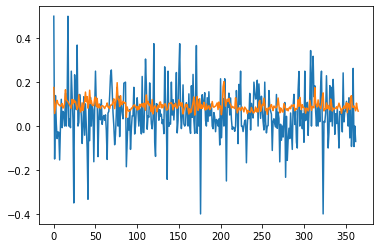

In [10]:
time_subs['pol'].plot()
time_comments['pol'].plot()

<AxesSubplot:>

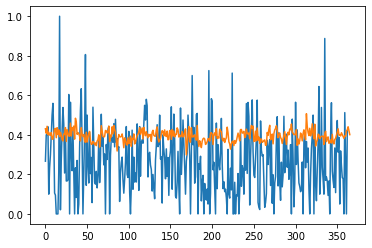

In [11]:
time_subs['sub'].plot()
time_comments['sub'].plot()

## Vader

In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

submissions['vs'] = [analyzer.polarity_scores(sentence) for sentence in submissions['title']]

In [22]:
submissions['vs_neg'] = [dict.get('neg') for dict in submissions['vs']]
submissions['vs_pos'] = [dict.get('pos') for dict in submissions['vs']]
submissions['vs_neu'] = [dict.get('neu') for dict in submissions['vs']]
submissions['vs_com'] = [dict.get('compound') for dict in submissions['vs']]

In [29]:
submissions.sample(15)

,submission_id,title,date,is_self,selftext,ups,upvote_ratio,num_comments,subreddit,image,domain,lem,sub,pol,vs,vs_neg,vs_pos,vs_neu,vs_com,flair_pol
1297,x1p646,Disney will launch a new card game to go up ag...,2022-08-30,0,,171,0.88,244,mtgfinance,0,polygon,Disney will launch a new card game to go up ag...,0.618182,0.078788,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,1.000,0.0000,None
732,v29h4n,took a way better picture of this card than wh...,2022-06-01,0,,1673,0.95,92,magicTCG,1,redd,took a way better picture of this card than wh...,0.450000,0.450000,"{'neg': 0.0, 'neu': 0.805, 'pos': 0.195, 'comp...",0.000,0.195,0.805,0.4404,None
168,yy58an,I accidentally touched some weird oil I found....,2022-11-17,0,,3121,0.94,116,magicTCG,1,redd,I accidentally touched some weird oil I found ...,1.000000,-0.500000,"{'neg': 0.313, 'neu': 0.687, 'pos': 0.0, 'comp...",0.313,0.000,0.687,-0.4767,None
1492,zuz3tk,"Merry Christmas to me, the only sealed stuff I...",2022-12-25,0,,114,0.83,45,mtgfinance,0,imgur,Merry Christmas to me the only sealed stuff I ...,1.000000,0.000000,"{'neg': 0.0, 'neu': 0.774, 'pos': 0.226, 'comp...",0.000,0.226,0.774,0.5423,None
44,suu2q2,[SLD] Basic Lands -Synthwave,2022-02-17,0,,4539,0.98,419,magicTCG,1,redd,SLD Basic Lands Synthwave,0.125000,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,1.000,0.0000,None
362,yge9z9,My friend only got to play a single game in al...,2022-10-29,0,,2382,0.98,249,magicTCG,1,imgur,My friend only got to play a single game in al...,0.497321,-0.149107,"{'neg': 0.089, 'neu': 0.685, 'pos': 0.226, 'co...",0.089,0.226,0.685,0.5267,None
1068,yyyi8o,Card Conjurer: The first victim of WOTC’s Prox...,2022-11-19,1,"https://cardconjurer.com/\n\nAbove link, but t...",349,0.90,247,mtgfinance,0,reddit,Card Conjurer The first victim of WOTC ’ s Pro...,0.191667,0.087500,"{'neg': 0.462, 'neu': 0.538, 'pos': 0.0, 'comp...",0.462,0.000,0.538,-0.7184,None
1051,vqj904,2X2 Collector Mythic Pull Rates,2022-07-03,1,After watching multiple cases worth of 2X2 col...,383,0.95,57,mtgfinance,0,reddit,2X2 Collector Mythic Pull Rates,0.000000,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,1.000,0.0000,None
1988,u9duzb,SNC Call It Now,2022-04-22,1,Not trying to steal anyone’s super secret spec...,53,0.84,161,mtgfinance,0,reddit,SNC Call It Now,0.000000,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,1.000,0.0000,None
604,urrlv1,[CLB] Monster Manual,2022-05-17,0,,1857,0.99,242,magicTCG,1,redd,CLB Monster Manual,0.000000,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,1.000,0.0000,None


<AxesSubplot:>

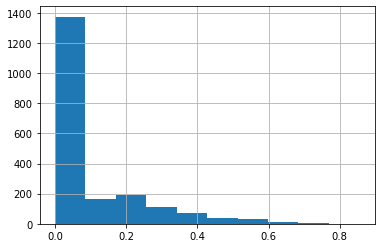

In [25]:
submissions.vs_pos.hist()

<AxesSubplot:>

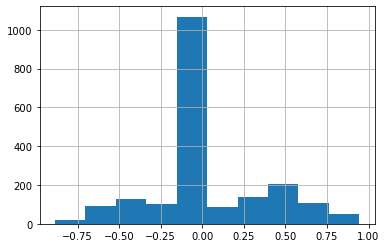

In [30]:
submissions.vs_com.hist()

<AxesSubplot:>

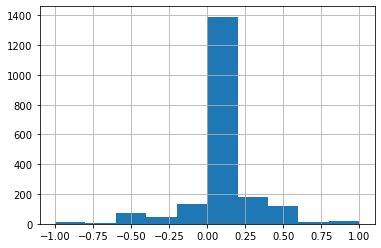

In [32]:
submissions.pol.hist()

In [33]:
time_subs = submissions.groupby(['date']).mean()
time_subs.reset_index(inplace=True)

In [40]:
time_subs.query("date == '2022-11-14'")

,date,ups,upvote_ratio,num_comments,sub,pol,vs_neg,vs_pos,vs_neu,vs_com
275,2022-11-14,1279.75,0.90375,419.5,0.15625,-0.05,0.068875,0.046875,0.884125,-0.095
